In [76]:
import os 
import getpass
from dotenv import load_dotenv

## retriever
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores.base import VectorStoreRetriever

## tool
from langgraph.prebuilt import ToolExecutor
from langchain.tools.retriever import create_retriever_tool

## agent
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage

## Nodes and Edges
import json
import operator
from typing import Annotated, Sequence, TypedDict

from langchain import hub
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_core.messages import BaseMessage, FunctionMessage, HumanMessage
from langchain.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolInvocation
from langchain_core.output_parsers import StrOutputParser

## Graph
from langgraph.graph import END, StateGraph

## Response
import pprint
from langchain_core.messages import HumanMessage



# from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
# 
# from langchain_core.messages import BaseMessage, FunctionMessage, HumanMessage
# from langchain.tools.render import format_tool_to_openai_function
# from langgraph.graph import END, StateGraph

## API Key Setting

In [77]:
def _set_if_undefined(var: str):
    # 주어진 환경 변수가 설정되어 있지 않다면 사용자에게 입력을 요청하여 설정합니다.
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


# OPENAI_API_KEY 환경 변수가 설정되어 있지 않으면 사용자에게 입력을 요청합니다.
_set_if_undefined("OPENAI_API_KEY")
# LANGCHAIN_API_KEY 환경 변수가 설정되어 있지 않으면 사용자에게 입력을 요청합니다.
_set_if_undefined("LANGCHAIN_API_KEY")

# LangSmith 추적 기능을 활성화합니다. (선택적)
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

In [78]:
load_dotenv()

False

In [79]:
input_data = "../참고논문_1.pdf"

## retriever(검색기) 생성

In [80]:
def embedding_file(file: str) -> VectorStoreRetriever:
    """문서를 청크 단위로 분할하고 임베딩 모델(text-embedding-ada-002)을 통해 임베딩하여 vector store에 저장합니다. 이후 vector store를 기반으로 검색하는 객체를 생성합니다. 

    Args:
        file (str): pdf 문서 경로

    Returns:
        VectorStoreRetriever: 검색기 
    """
    
    ## 긴 텍스트를 작은 청크로 나누는 데 사용되는 클래스
    splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(       
        chunk_size=500,         ## 최대 청크 길이 정의
        chunk_overlap=100,      ## 청크 간 겹침 길이 정의
        separators=["\n\n"]     ## 텍스트를 나눌 때 사용할 구분자를 지정 (문단)
    )
    
    ## PDF 파일 불러오기
    loader = PyPDFLoader(f"{file}")
    docs = loader.load_and_split(text_splitter=splitter)
    
    ## Embedding 생성 및 vector store에 저장
    embeddings = OpenAIEmbeddings()
    vector_store = FAISS.from_documents(
        documents=docs,         ## 벡터 저장소에 추가할 문서 리스트
        embedding=embeddings    ## 사용할 임베딩 함수
    )
    
    ## 검색기로 변환: 현재 벡터 저장소를 기반으로 VectorStoreRetriever 객체를 생성하는 기능을 제공
    retriever = vector_store.as_retriever(
        search_type="similarity"    ## 어떻게 검색할 것인지? default가 유사도
    )

    return retriever

In [81]:
retriever = embedding_file(file=input_data)

In [82]:
# 논문에 대한 정보를 검색하고 반환하는 도구를 생성합니다.
tool = create_retriever_tool(
    retriever,
    "retrieve_papers",
    "Search and return information about papers.",
)

tools = [tool]

In [83]:
# 도구들을 실행할 ToolExecutor 객체를 생성합니다.
tool_executor = ToolExecutor(tools)

C:\Users\ghckd\AppData\Local\Temp\ipykernel_3616\2394088372.py:2: LangGraphDeprecationWarning: ToolExecutor is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  tool_executor = ToolExecutor(tools)


## Agent 생성

In [84]:
class AgentState(TypedDict):
    # AgentState 클래스는 메시지 시퀀스를 포함하는 타입 딕셔너리입니다.
    messages: Annotated[Sequence[BaseMessage], operator.add]

## Nodes and Edges 

#### Edges

In [85]:
def should_retrieve(state):
    """
    에이전트가 더 많은 정보를 검색해야 하는지 또는 프로세스를 종료해야 하는지 결정합니다.

    이 함수는 상태의 마지막 메시지에서 함수 호출을 확인합니다. 함수 호출이 있으면 정보 검색 프로세스를 계속합니다. 그렇지 않으면 프로세스를 종료합니다.

    Args:
        state (messages): 현재 상태

    Returns:
        str: 검색 프로세스를 "계속"하거나 "종료"하는 결정
    """

    print("---DECIDE TO RETRIEVE---")
    messages = state["messages"]
    last_message = messages[-1]

    # 함수 호출이 없으면 종료합니다.
    if "function_call" not in last_message.additional_kwargs:
        print("---DECISION: DO NOT RETRIEVE / DONE---")
        return "end"
    # 그렇지 않으면 함수 호출이 있으므로 계속합니다.
    else:
        print("---DECISION: RETRIEVE---")
        return "continue"

In [86]:
def grade_documents(state):
    """
    검색된 문서가 질문과 관련이 있는지 여부를 결정합니다.

    Args:
        state (messages): 현재 상태

    Returns:
        str: 문서가 관련이 있는지 여부에 대한 결정
    """

    print("---CHECK RELEVANCE---")

    # 데이터 모델
    class Grade(BaseModel):
        """관련성 검사를 위한 이진 점수."""

        binary_score: str = Field(description="'yes' 또는 'no'의 관련성 점수")

    # LLM
    model = ChatOpenAI(
        temperature=0, 
        model="gpt-4o", 
        streaming=True
    )

    # 도구
    grade_tool = convert_to_openai_tool(Grade)

    # 도구와 강제 호출을 사용한 LLM
    llm_with_tool = model.bind(
        tools=[grade_tool],
        # tool_choice={"type": "function", "function": {"name": "grade"}},
    )

    # 파서
    parser_tool = PydanticToolsParser(tools=[Grade])

    # 프롬프트
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # 체인
    chain = prompt | llm_with_tool | parser_tool

    messages = state["messages"]
    question = messages[0].content
    docs = messages[-1].content

    score = chain.invoke({"question": question, "context": docs})

    grade = score[0].binary_score

    if grade == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "yes"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "no"

#### Nodes

In [87]:
def retrieve(state):
    """
    도구를 사용하여 검색을 실행합니다.

    Args:
        state (messages): 현재 상태

    Returns:
        dict: 검색된 문서가 추가된 업데이트된 상태
    """
    print("---EXECUTE RETRIEVAL---")
    messages = state["messages"]
    # 계속 조건을 기반으로 마지막 메시지가 함수 호출을 포함하고 있음을 알 수 있습니다.
    last_message = messages[-1]
    
    if "function_call" not in last_message.additional_kwargs:
        print("---No function call in last message---")
        return {"messages": messages}
    
    # 함수 호출에서 ToolInvocation을 구성합니다.
    action = ToolInvocation(
        tool=last_message.additional_kwargs["function_call"]["name"],
        tool_input=json.loads(
            last_message.additional_kwargs["function_call"]["arguments"]
        ),
    )
    # 도구 실행자를 호출하고 응답을 받습니다.
    response = tool_executor.invoke(action)
    function_message = FunctionMessage(content=str(response), name=action.tool)

    # 이것은 기존 목록에 추가될 것이므로 리스트를 반환합니다.
    return {"messages": [function_message]}

In [88]:
# def agent(state):
#     """
#     현재 상태를 기반으로 에이전트 모델을 호출하여 응답을 생성합니다. 질문에 따라 검색 도구를 사용하여 검색을 결정하거나 단순히 종료합니다.

#     Args:
#         state (messages): 현재 상태

#     Returns:
#         dict: 메시지에 에이전트 응답이 추가된 업데이트된 상태
#     """
#     print("---CALL AGENT---")
#     messages = state["messages"]
#     model = ChatOpenAI(
#         temperature=0, 
#         streaming=True,
#         model="gpt-4o"
#         )
#     functions = [format_tool_to_openai_function(t) for t in tools]
#     model = model.bind_functions(functions)
#     response = model.invoke(messages)
#     # 이것은 기존 목록에 추가될 것이므로 리스트를 반환합니다.
#     return {"messages": [response]}

In [89]:
def rewrite(state):
    """
    질문을 변형하여 더 나은 질문을 생성합니다.

    Args:
        state (messages): 현재 상태

    Returns:
        dict: 재구성된 질문이 추가된 업데이트된 상태
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # 평가자
    model = ChatOpenAI(
        temperature=0, model="gpt-4o", streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}

In [90]:
def generate(state):
    """
    답변 생성

    Args:
        state (messages): 현재 상태

    Returns:
         dict: 재구성된 질문이 추가된 업데이트된 상태
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    # 프롬프트
    prompt = PromptTemplate(
    template="""
    Based on the following document, please provide an answer to the given question.

    Document:
    {context}

    Question:
    {question}

    Answer:
    """,
    input_variables=["context", "question"],
    )

    # LLM
    llm = ChatOpenAI(model_name="gpt-4o",
                     temperature=0, streaming=True)
    print("-----------")
    print(docs)
    # 후처리
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # 체인
    rag_chain = prompt | llm | StrOutputParser()

    # 실행
    response = rag_chain.invoke({"context": format_docs(docs), "question": question})
    return {"messages": [response]}

## Graph

In [91]:
# langgraph.graph에서 StateGraph와 END를 가져옵니다.
workflow = StateGraph(AgentState)

# 순환할 노드들을 정의합니다.
workflow.add_node("retrieve", retrieve)  # 정보 검색 노드를 추가합니다.
# workflow.add_node("agent", agent)  # 에이전트 노드를 추가합니다.
workflow.add_node("generate", generate)  # 정보 생성 노드를 추가합니다.
workflow.add_node("rewrite", rewrite)  # 정보 재작성 노드를 추가합니다.

In [92]:
# 에이전트 노드 호출하여 검색 여부 결정
workflow.set_entry_point("retrieve")

# 검색 후 생성 단계로 이동
workflow.add_edge("retrieve", "generate")

# # 검색 여부 결정 노드를 직접 추가
# workflow.add_conditional_edges(
#     "retrieve",  # 검색 후 관련성을 평가
#     should_retrieve,  # 검색 계속 여부를 결정
#     {
#         "continue": "generate",  # 계속 검색
#         "end": END,             # 종료
#     },
# )

# 문서 평가 노드
workflow.add_conditional_edges(
    "generate",
    grade_documents,
    {
        "yes": END,  # 문서가 관련 있으면 생성
        "no": "rewrite",    # 문서가 관련 없으면 재작성
    },
)

# 응답 생성 후 종료
workflow.add_edge("generate", END)

# 질문 수정 후 다시 검색
workflow.add_edge("rewrite", "retrieve")

# 컴파일
app = workflow.compile()

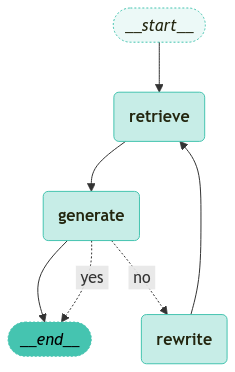

In [93]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

## Response

In [94]:
# HumanMessage 객체를 사용하여 질문 메시지를 정의합니다.
inputs = {
    "messages": [
        HumanMessage(
            content="""Below are instructions for filling out 23 items by referring to the examples. The values shown to the right of the colon (“:”) are examples; please delete them after reviewing and rewrite them with the values found in the PDF. If any item is not mentioned in the PDF, do not remove it—write “None.”
1. Electrode (only coin cell)
1.1 Cathode active material: NCM-622
1.2 Lithium source: LiOH
1.3 Nickel supplied during the co-precipitation process of the precursor: NiSO4·6H2O
1.4 Cobalt supplied during the co-precipitation process of the precursor: CoSO4·7H2O
1.5 Manganese supplied during the co-precipitation process of the precursor: MnSO4·H2O
1.6 Co-precipitation solution: NaOH, 4M
1.7 Crystallization method (Hydrothermal or Sintering): Hydrothermal
1.8 Crystallization temperature: 100°C
1.9 Crystallization time: 12 hr
1.10 Active material : Conductive additive : Binder ratio: 90 : 5 : 5
1.11 Electrolyte: LiPF6 (EC, EMC, DEC mixture in a 1:1:1 volume ratio)
1.12 Doping: Zr4+ doping
1.13 Coating: ZrO2 coating
1.14 Additive: FEC 10% addition
1.15 Electrode thickness: 100 µm
1.16 only Cathode Electrode diameter: 14π
1.17 Loading density: 0.005 g/cm^2
1.18 Commercial NCM (check if specified in the paper): No
2. Cathode Performance
2.1 Capacity at all C-rate, mAh/g (with electrode state; e.g., coated or uncoated) : 214.5 mAh/g
2.2 Voltage range: 2.8–4.3 V
2.3 Temperature: Room temperature and 55°C
3. Cathode Equipment
3.1 Explanation of SEM results (indicate figure numbers as well):
ex) Fig. 2a, b;the NCM-622 seems to have more or less a spherical morphology with a diameter of 3–5 µm, composed of densely packed primary parti-cles
3.2 Explanation of TEM results: None"""
        )
    ]
}
# app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
for output in app.stream(inputs):
    print(output)
    # 출력된 결과에서 키와 값을 순회합니다.
    for key, value in output.items():
        # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        # 출력 값을 예쁘게 출력합니다.
        pprint.pprint(value, indent=2, width=80, depth=None)
    # 각 출력 사이에 구분선을 추가합니다.
    pprint.pprint("\n---\n")

---EXECUTE RETRIEVAL---
---No function call in last message---
{'retrieve': {'messages': [HumanMessage(content='Below are instructions for filling out 23 items by referring to the examples. The values shown to the right of the colon (“:”) are examples; please delete them after reviewing and rewrite them with the values found in the PDF. If any item is not mentioned in the PDF, do not remove it—write “None.”\n1. Electrode (only coin cell)\n1.1 Cathode active material: NCM-622\n1.2 Lithium source: LiOH\n1.3 Nickel supplied during the co-precipitation process of the precursor: NiSO4·6H2O\n1.4 Cobalt supplied during the co-precipitation process of the precursor: CoSO4·7H2O\n1.5 Manganese supplied during the co-precipitation process of the precursor: MnSO4·H2O\n1.6 Co-precipitation solution: NaOH, 4M\n1.7 Crystallization method (Hydrothermal or Sintering): Hydrothermal\n1.8 Crystallization temperature: 100°C\n1.9 Crystallization time: 12 hr\n1.10 Active material : Conductive additive : Bind

AttributeError: 'str' object has no attribute 'page_content'

In [51]:
pprint.pprint(value["messages"])

[AIMessage(content='어떤 논문에서 키워드를 추출해드릴까요? 논문의 제목이나 주제를 알려주시면 도와드리겠습니다.', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d28bcae782'}, id='run-afd99121-0896-4d21-8c8b-6b31cf0f12fb-0')]
